# Comp 388 | Assignment 5: ResNeXt-18 Implementation

This notebook implements a ResNeXt-18 model for CIFAR-10 using the same  structure as the ResNet-18 lecture notebook.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)

# Flatten labels to 1D
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Combine so we can split 70/30 as requested
x_combined = np.concatenate([x_train, x_test], axis=0)
y_combined = np.concatenate([y_train, y_test], axis=0)

# Normalize
x_combined = x_combined.astype("float32") / 255.0

# 70/30 split
x_train, x_test, y_train, y_test = train_test_split(
    x_combined, y_combined, test_size=0.30, random_state=7, stratify=y_combined
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


((42000, 32, 32, 3), (18000, 32, 32, 3), (42000,), (18000,))

## ResNeXt-18 Architecture


In [10]:
def resnext_basic_block(x, filters, stride=1, cardinality=8):
    if filters % cardinality != 0:
        raise ValueError("filters must be divisible by cardinality")

    shortcut = x

    # conv1 are standard
    x = layers.Conv2D(
        filters, 3, strides=stride, padding="same",
        use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # conv2 are grouped
    x = layers.Conv2D(
        filters, 3, strides=1, padding="same",
        groups=cardinality, use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def make_resnext_stage(x, filters, blocks, first_stride, cardinality):
    x = resnext_basic_block(x, filters=filters, stride=first_stride, cardinality=cardinality)
    for _ in range(1, blocks):
        x = resnext_basic_block(x, filters=filters, stride=1, cardinality=cardinality)
    return x


def build_resnext18(num_classes=10, cardinality=8, dropout_rate=0.5):
    inputs = keras.Input(shape=(32, 32, 3))

    # Start using same ordering as ResNet lecture notebook
    x = layers.Conv2D(32, kernel_size=7, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # 4 stages, 2 blocks each to match ResNet-18 style
    x = make_resnext_stage(x, filters=32, blocks=2, first_stride=1, cardinality=cardinality)
    x = make_resnext_stage(x, filters=64, blocks=2, first_stride=2, cardinality=cardinality)
    x = make_resnext_stage(x, filters=128, blocks=2, first_stride=2, cardinality=cardinality)
    x = make_resnext_stage(x, filters=256, blocks=2, first_stride=2, cardinality=cardinality)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="ResNeXt18_CIFAR10")


In [4]:
model = build_resnext18(cardinality=8, dropout_rate=0.5)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "ResNeXt18_CIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      4,704 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 32)  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 32)  │      9,216 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 32)  │      1,152 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 8, 8, 32)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 32)  │      9,216 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 32)  │      1,152 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 8, 8, 32)  │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,435,370 (5.48 MB)

 Trainable params: 1,430,570 (5.46 MB)

 Non-trainable params: 4,800 (18.75 KB)

In [5]:
# Train with assignment settings
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=2,
)


Epoch 1/50
1313/1313 - 48s - 36ms/step - accuracy: 0.2470 - loss: 2.5739 - val_accuracy: 0.3893 - val_loss: 1.7862
Epoch 2/50
1313/1313 - 12s - 9ms/step - accuracy: 0.3669 - loss: 1.8491 - val_accuracy: 0.4461 - val_loss: 1.5335
Epoch 3/50
1313/1313 - 19s - 14ms/step - accuracy: 0.4390 - loss: 1.5976 - val_accuracy: 0.4730 - val_loss: 1.4563
Epoch 4/50
1313/1313 - 10s - 8ms/step - accuracy: 0.4930 - loss: 1.4373 - val_accuracy: 0.5189 - val_loss: 1.3428
Epoch 5/50
1313/1313 - 9s - 7ms/step - accuracy: 0.5318 - loss: 1.3236 - val_accuracy: 0.5211 - val_loss: 1.3487
Epoch 6/50
1313/1313 - 10s - 8ms/step - accuracy: 0.5730 - loss: 1.2271 - val_accuracy: 0.5467 - val_loss: 1.2916
Epoch 7/50
1313/1313 - 10s - 8ms/step - accuracy: 0.6028 - loss: 1.1366 - val_accuracy: 0.5178 - val_loss: 1.3878
Epoch 8/50
1313/1313 - 10s - 8ms/step - accuracy: 0.6350 - loss: 1.0486 - val_accuracy: 0.5054 - val_loss: 1.4280
Epoch 9/50
1313/1313 - 10s - 8ms/step - accuracy: 0.6592 - loss: 0.9791 - val_accuracy:

In [7]:
# Training and testing accuracy
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training accuracy: {train_acc:.4f}")
print(f"Testing accuracy:  {test_acc:.4f}")


Training accuracy: 0.9793
Testing accuracy:  0.6089


We see that this also performed well on the training sample and bad on the testing sample. This hints towards overfitting meaning the model was just memorizing the data for the training sample and didn't generalize well.

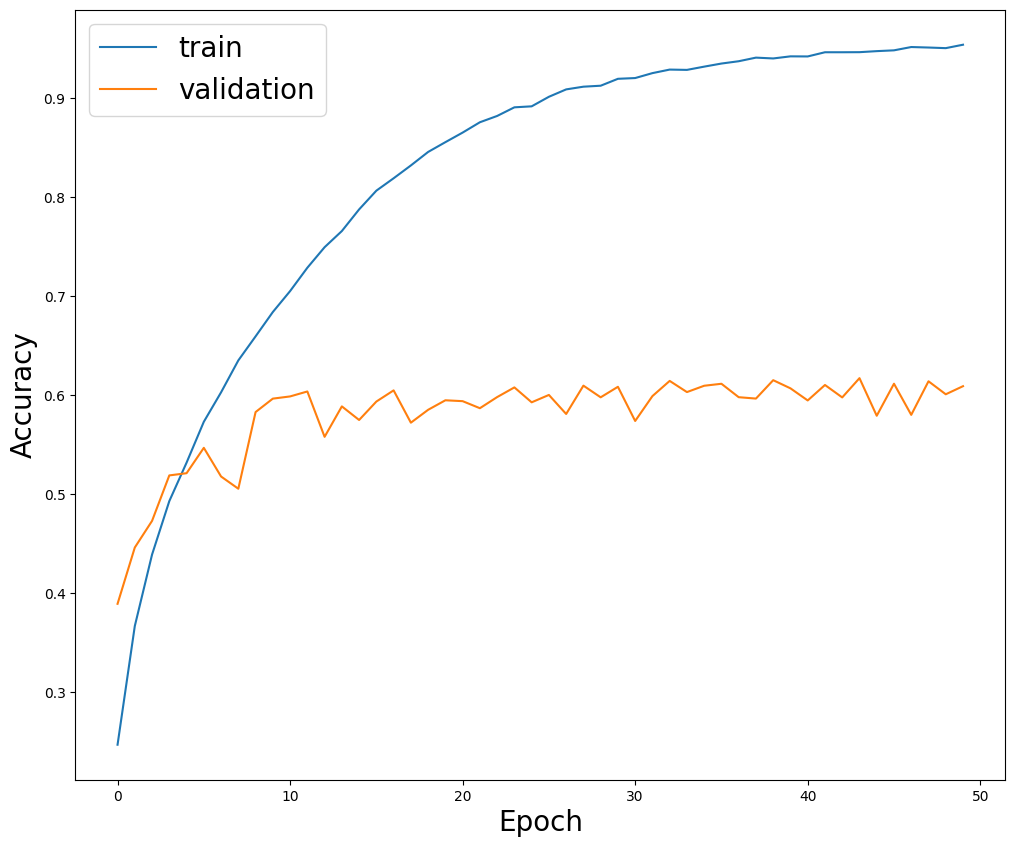

In [8]:
import pandas as pd

# Visualize training history
def plot_history(hist):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

A really smooth training curve which is nice, but we see that the training and validation are not close to each other or converging the same at all.

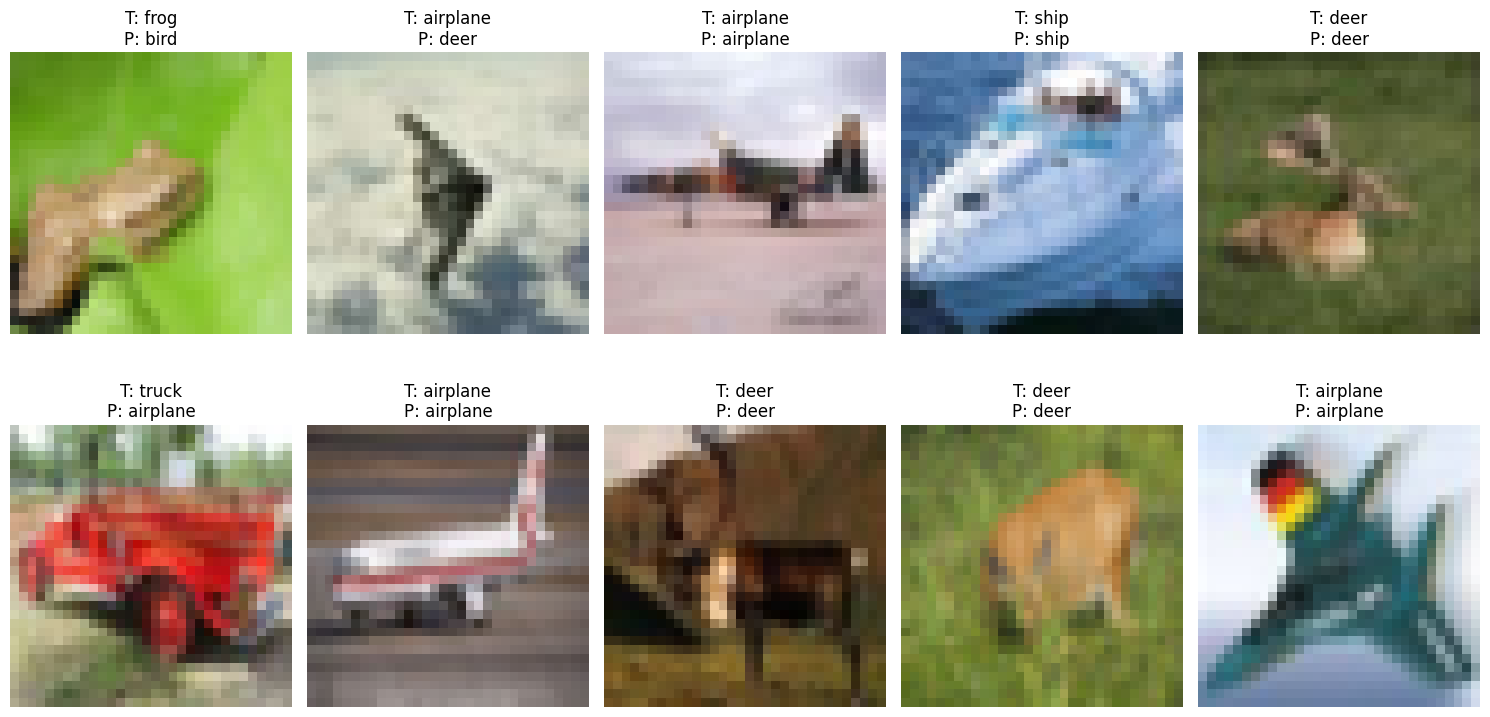

In [9]:
# Predict the last 10 images from the test set
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Last 10 samples
images = x_test[-10:]
labels = y_test[-10:]

fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()

for i in range(10):
    img = images[i]
    true_label = labels[i]

    # predict one image
    pred = model.predict(img[None, ...], verbose=0).argmax()

    ax[i].imshow(img)
    ax[i].set_title(
        f"T: {CLASS_NAMES[true_label]}\nP: {CLASS_NAMES[pred]}",
        fontsize=12
    )
    ax[i].axis("off")

plt.tight_layout()

We see it predicts around 60% of the images correctly, which is what we would expect based on the testing accuracy we saw above.